# Radial distribution g(r) of the sinkhole positions

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from lidar_data_analyzer import LidarDataSet
from lidar_data_analyzer import radial_distribution

### Testing on small dataset

In [3]:
lds1 = LidarDataSet.from_csv_file("./data/dataset2/TM1_445_82.txt")
lds1.find_sinkholes()

LOG: find_sinkholes: found 284 sinkholes


PLOTTING


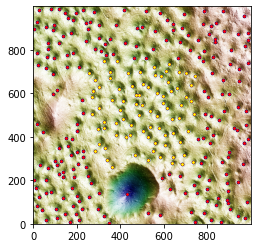

In [4]:
lds1.plot(centers=True)

g(r) using pbc

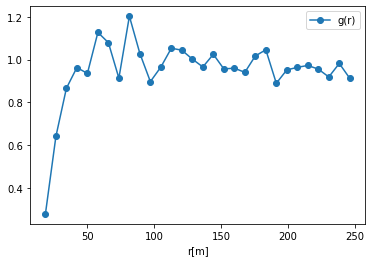

In [5]:
_ = radial_distribution(lds1, method="pbc", plot=True)

g(r) only for nonborder data -> this dataset is way too small for it to look reasonably good, but it's just a test

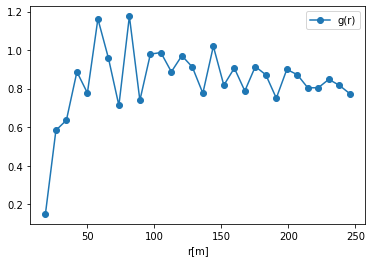

In [6]:
_ = radial_distribution(lds1, method="nonborder", plot=True)

## Our target dataset

In [7]:
data_segment_filenames = [[f"TM1_{x}_{y}" for y in range(80,84+1)] for x in range(442,447+1)]

selected_range_points = [[1200, 4040],
                         [1586, 3777],
                         [2500, 3440],
                         [2852, 3100],
                         [3290, 2973],
                         [3790, 2382],
                         [3793, 2091],
                         [4470, 1700],
                         [6000, 270],
                         [6000, 0],
                         [4025, 0],
                         [2340, 1646],
                         [2280, 1930],
                         [1492, 2500],
                         [1193, 3120],
                         [465, 3700],
                         [310, 4385],
                         [380, 4600],
                         [619,4700],
                         [1070,4316]]

ldsl = LidarDataSet.from_array_of_csv_files(data_segment_filenames,
                                            filename_prefix="./data/dataset2/",
                                            selected_range_points=selected_range_points)

In [8]:
ldsl.find_sinkholes()

LOG: find_sinkholes: found 6791 sinkholes


PLOTTING


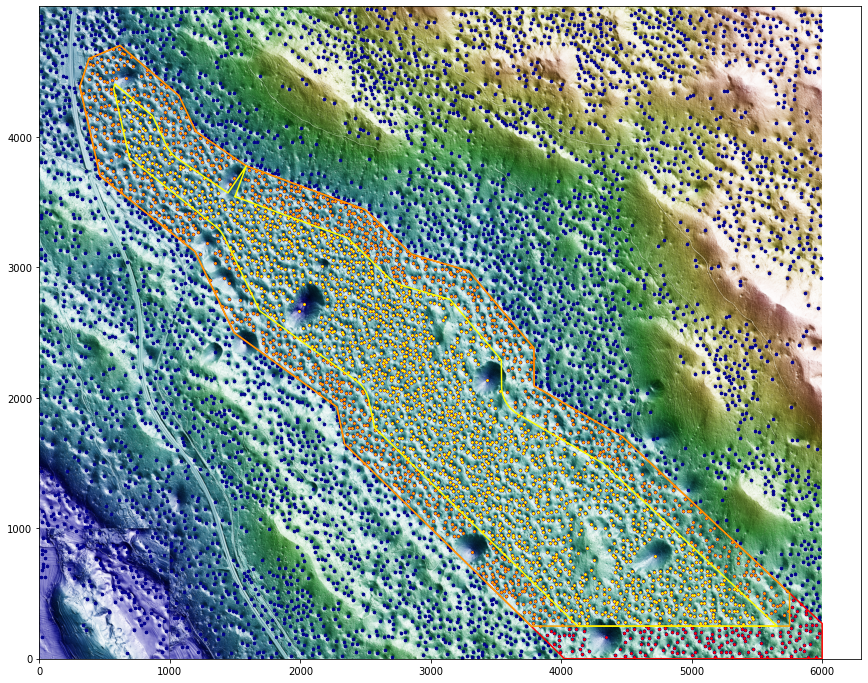

In [8]:
ldsl.plot(edges=False, centers=True, analyzed_region=True, verbose=False, fig_size=(16,12))

### g(r) for the inner (yellow) points using nonborder
We find g(r) for all the inner (yellow) points analyzing their surrounding of radius maxR=250m. For that we also use the points in the buffer -> orange and red points on the plot -> to provide the surrounding for all the inner points

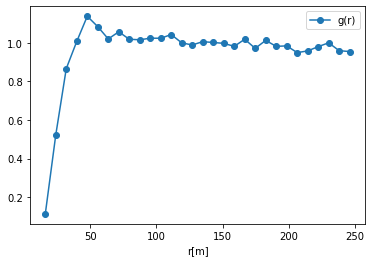

In [9]:
_ =radial_distribution(ldsl, method="nonborder", plot=True)

### g(r) for all the points in dataset using pbc
Here we actually use ALL the data in the 5km x 6km dataset including e.g. regions with mountains so it is not really useful, but still, I wanted to see what it looks like

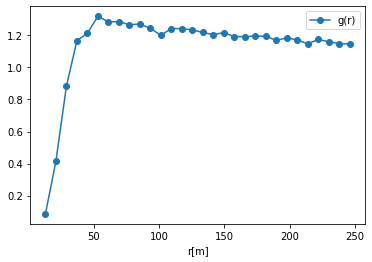

In [10]:
_ = radial_distribution(ldsl, method="pbc", plot=True)

## Using pbc for rectangular subsets of ldsl

### Rotated dataset

Bc the plain is directed NW to SE it is easier to extract rectangular portions if we rotate it by 45 deg.

PLOTTING


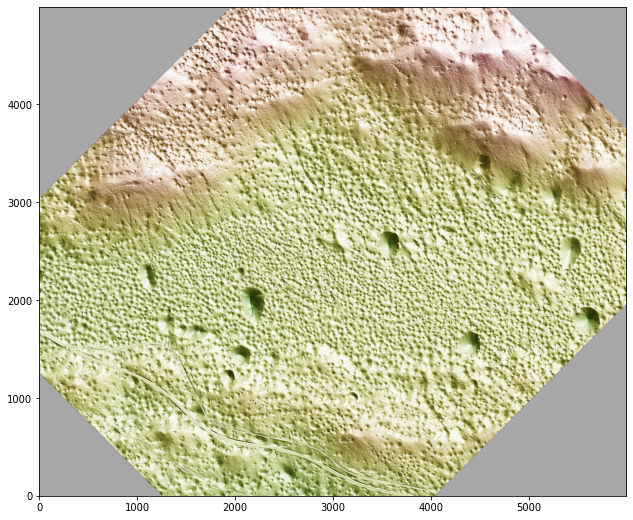

In [11]:
from scipy.ndimage import rotate
lds_r = LidarDataSet(rotate(ldsl.dataset, 45, reshape=False))
lds_r.plot(fig_size=(12,9))

### Rectangular subsets of the rotated dataset

In [12]:
subsets = [[2309, 4232, 1573, 2414], #duży obszar
           #[2309, 4783, 1684, 2414],
            [1396, 1975, 1774, 2510],
            [  48,  987, 1700, 2353]]

# [2309, 4783, 1684, 2414], # duży obszar -- rozszerzenie w prawo (z obciętym z dołu)
# [2309, 4803, 1573, 2917],# rozszerzenie włączające duży lej -> mniej klarowne ale podobne maksima

lds_subsets = []

for i, subset_i in enumerate(subsets):

    minx, maxx, miny, maxy = subset_i
    lds_subsets.append(LidarDataSet.from_rectangular_subset(lds_r, minx, maxx, miny, maxy))


We have to find sinkholes first

In [21]:
for lds_subset in lds_subsets:
    lds_subset.find_sinkholes()

LOG: find_sinkholes: found 715 sinkholes
LOG: find_sinkholes: found 185 sinkholes
LOG: find_sinkholes: found 209 sinkholes


#### First subset

PLOTTING


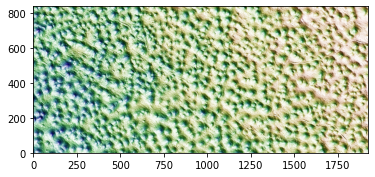

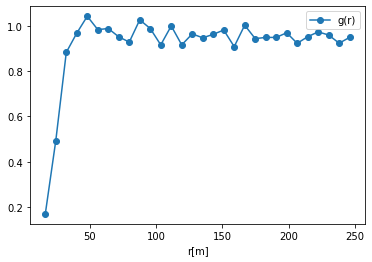

In [27]:
s0 = lds_subsets[0]
s0.plot()
_ = radial_distribution(s0, method="pbc", plot=True)

#### 2nd subset

PLOTTING


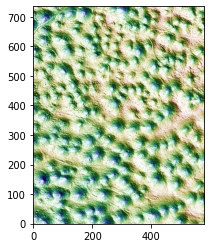

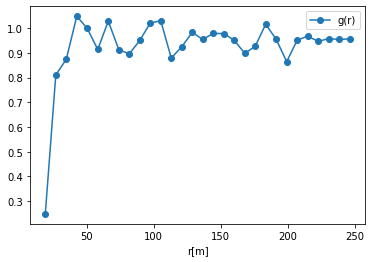

In [30]:
s1 = lds_subsets[1]
s1.plot()
_ = radial_distribution(s1, method="pbc", plot=True)

#### 3rd subset

PLOTTING


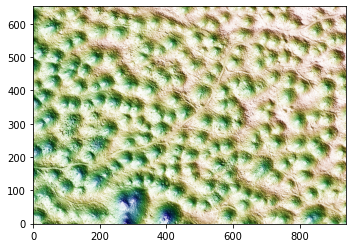

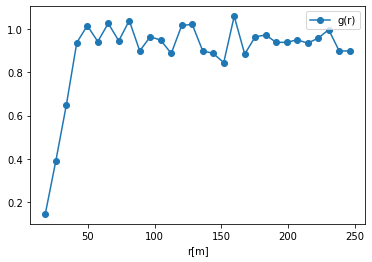

In [31]:
s2= lds_subsets[2]
s2.plot()
_ = radial_distribution(s2, method="pbc", plot=True)

## Average g(r) for all the subsets

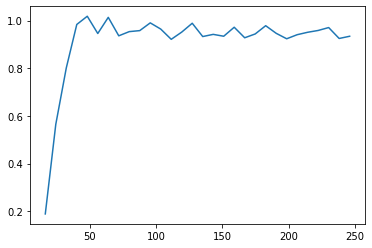

In [32]:
n_bins = 30 # also the default value for radial_distribution() function
r_vals = np.zeros(n_bins)
rds = np.zeros((len(subsets), n_bins))
    
for i, s in enumerate(lds_subsets):
    rd_data = radial_distribution(s, method="pbc", plot=False)
    # r_vals are common for all subsets so we define them for the 1st
    if i == 0:
        r_vals = rd_data["bin_center_positions"]
    rds[i] = rd_data["radial_distribution_values"]

# g(r) average over all subsets
rd = np.mean(rds, axis=0)
# print(rd)
plt.plot(r_vals, rd)

## Tests

In [16]:
ll = ldsl.sinkholes

In [41]:
lla = ll[ll["analyzed"]]
lla

,center_x,center_y,center,analyzed,analyzed_nonborder,inner
1,2026,2722,"(2026, 2722)",True,True,True
35,1991,2664,"(1991, 2664)",True,True,True
144,4341,166,"(4341, 166)",True,False,False
159,3433,2136,"(3433, 2136)",True,True,True
160,3317,820,"(3317, 820)",True,True,False
...,...,...,...,...,...,...
5223,5955,13,"(5955, 13)",True,False,False
5259,5372,808,"(5372, 808)",True,True,False
5268,5351,775,"(5351, 775)",True,True,False
5297,5307,891,"(5307, 891)",True,True,False


In [33]:
ll["analyzed"]

0       False
1        True
2       False
3       False
4       False
        ...  
6786    False
6787    False
6788    False
6789    False
6790    False
Name: analyzed, Length: 6791, dtype: bool

In [37]:
np.where((ll["analyzed"]) & (ll["inner"]==False))

(array([ 144,  160,  180, ..., 5268, 5297, 5339]),)

In [38]:
ll[(ll["analyzed"]) & (ll["inner"]==False)] 

,center_x,center_y,center,analyzed,analyzed_nonborder,inner
144,4341,166,"(4341, 166)",True,False,False
160,3317,820,"(3317, 820)",True,True,False
180,667,4453,"(667, 4453)",True,True,False
188,1463,3641,"(1463, 3641)",True,True,False
196,1492,3681,"(1492, 3681)",True,True,False
...,...,...,...,...,...,...
5223,5955,13,"(5955, 13)",True,False,False
5259,5372,808,"(5372, 808)",True,True,False
5268,5351,775,"(5351, 775)",True,True,False
5297,5307,891,"(5307, 891)",True,True,False


In [39]:
ll[ll["inner"]]

,center_x,center_y,center,analyzed,analyzed_nonborder,inner
1,2026,2722,"(2026, 2722)",True,True,True
35,1991,2664,"(1991, 2664)",True,True,True
159,3433,2136,"(3433, 2136)",True,True,True
262,2168,3012,"(2168, 3012)",True,True,True
288,4718,790,"(4718, 790)",True,True,True
...,...,...,...,...,...,...
4733,5284,537,"(5284, 537)",True,True,True
4746,5345,526,"(5345, 526)",True,True,True
4871,5375,502,"(5375, 502)",True,True,True
4887,5321,531,"(5321, 531)",True,True,True


In [14]:
lds1.sinkholes[["center_x", "center_y"]].to_numpy()

array([[433, 136],
       [463, 760],
       [587, 681],
       [557, 721],
       [280, 973],
       [  4, 897],
       [394, 619],
       [478, 902],
       [438, 692],
       [500, 906],
       [ 90, 688],
       [634, 612],
       [174, 875],
       [617, 533],
       [598, 589],
       [327, 746],
       [ 67, 832],
       [519, 763],
       [492, 699],
       [ 32, 271],
       [610, 701],
       [300, 436],
       [211, 720],
       [504, 426],
       [181, 935],
       [449, 455],
       [314, 795],
       [474, 817],
       [ 91, 891],
       [454, 631],
       [243, 839],
       [383, 465],
       [256, 691],
       [640, 483],
       [352, 696],
       [471, 551],
       [742,   7],
       [ 97, 764],
       [106,  69],
       [486, 501],
       [267, 186],
       [200, 460],
       [623, 733],
       [560, 685],
       [681, 546],
       [  6, 202],
       [763, 220],
       [148, 967],
       [ 22, 730],
       [607, 410],
       [ 18, 926],
       [198, 970],
       [250,

## ---- ARCH ----

In [18]:
# np.loadtxt(filename, delimiter=";")[:,2].reshape(1000,1000)
a = np.loadtxt("./data/dataset2/TM1_445_82.txt", delimiter=";")[:,2].reshape(1000,1000)
print(type(a), a.shape, "\n", a)

<class 'numpy.ndarray'> (1000, 1000) 
 [[529.62 530.09 530.11 ... 533.15 533.18 533.2 ]
 [529.48 529.73 530.11 ... 533.1  533.19 533.27]
 [529.4  529.53 529.75 ... 533.12 533.09 533.18]
 ...
 [538.15 538.15 538.2  ... 564.   564.13 564.13]
 [538.17 538.17 538.13 ... 563.97 563.96 564.28]
 [537.97 537.94 537.97 ... 563.87 563.98 564.19]]


In [17]:
b = pd.read_csv("./data/dataset2/TM1_445_82.txt", delimiter=";", header=None).values[:,2].reshape(1000,1000)
print(type(b), b.shape, "\n", b)
#a[:,2].reshape(1000,1000)

<class 'numpy.ndarray'> (1000, 1000) 
 [[529.62 530.09 530.11 ... 533.15 533.18 533.2 ]
 [529.48 529.73 530.11 ... 533.1  533.19 533.27]
 [529.4  529.53 529.75 ... 533.12 533.09 533.18]
 ...
 [538.15 538.15 538.2  ... 564.   564.13 564.13]
 [538.17 538.17 538.13 ... 563.97 563.96 564.28]
 [537.97 537.94 537.97 ... 563.87 563.98 564.19]]


In [ ]:
# extracted from LidarDataSegment

# def find_radial_distribution_distances_PBC(self):
    #     """calculates distances between sinhole centers for radial distribution (uses periodic boundary conditions)"""

    #     # we analyze every pair i,j; d(i,j) == d(j,i) so we just calculate it once and increment the corresponding
    #     # bin twice
    #     # density of sinkholes n = (# of sinkholes) / (total area)
    #     lenX, lenY = self.lenX, self.lenY # de facto aliases for readibility
    #     N = len(self.sinkholes)
    #     print(f"N:{N}")
    #     density = N / (lenX * lenY)

    #     distances = []
        
    #     for i, j in itertools.combinations(range(len(self.sinkholes)),2):
    #         ix, iy = self.sinkholes.at[i, 'center_x'], self.sinkholes.at[i, 'center_y']
    #         jx, jy = self.sinkholes.at[j, 'center_x'], self.sinkholes.at[j, 'center_y']
    #         dx0 = abs(ix - jx)
    #         dy0 = abs(iy - jy)
    #         dx = min(dx0, abs(lenX - dx0))
    #         dy = min(dy0, abs(lenY - dy0))
    #         d = np.sqrt(dx ** 2 + dy ** 2)
    #         distances.append(d)
        
    #     return {"distances": distances,
    #             "maxR": min([lenX, lenY]) / 2,
    #             "N": N,
    #             "density": density}
            

# OTHER ONE

  # def radial_distribution(self, rmax=250):
    #     buffer = self.analyzed_range.exterior.buffer(-rmax, single_sided=True)
    #     # all_sinkholes = self.sinkholes["center"]
    #     # inner_sinkholes = [p for p in all_sinkholes if Point(p).within(buffer)]

    #     # distances = []
    #     # for ish in inner_sinkholes:
    #     #     for osh in all_sinkholes:
    #     #         distances.append(np.sqrt((ish[0]-osh[0])**2 + (ish[1]-ish[0])**2))
        
    #     # density = len(all_sinkholes) / self.analyzed_range.area
    #     # n_of_bins = 15
    #     # dr = radial_max / n_of_bins
    #     # bin_edges = [dr * n for n in range(0,n_of_bins + 1)]
    #     # hist, _ = np.histogram(density, bins=bin_edges)
    #     # hist_norm = [b / (2 * np.pi * r * dr * density) for b,r in zip(hist, bin_edges[:-1])]
    #     # plt.plot(bin_edges[:-1],hist_norm)
    #     # plt.show()
    #     # input()

    #     #=-----------------------------------

    #     n_of_bins = 25


    #     all_sinkholes = self.sinkholes["center"]
    #     inner_sinkholes = [p for p in all_sinkholes if not Point(p).within(buffer)]

    #     all_x = []
    #     all_y = []
    #     for p in all_sinkholes:
    #         all_x.append(p[0])
    #         all_y.append(p[1])
        
    #     inner_x = []
    #     inner_y = []
    #     for p in inner_sinkholes:
    #         inner_x.append(p[0])
    #         inner_y.append(p[1])

    #     plt.scatter(all_x, all_y, color="red", s=5)
    #     plt.scatter(inner_x, inner_y, color="green", s=2)
    #     plt.show()
    #     # input()



    #     n_of_inner_sinkholes = len(inner_sinkholes)

    #     density = len(all_sinkholes) / self.analyzed_range.area
    #     print(f"density: {density}")

    #     dr = rmax / n_of_bins
    #     bin_center_positions = [((i * dr) + (dr / 2)) for i in range(n_of_bins)]
    #     bins = [0 for i in range(n_of_bins)]

    #     for ish in inner_sinkholes:
    #         for osh in all_sinkholes:
    #             d = np.sqrt((ish[0]-osh[0])**2 + (ish[1]-osh[1])**2)
    #             if 1 < d < rmax:
    #                 bins[int(d // dr)] += 1  # index of bin we want to increment is the int part of d/dr

    #     # print(f"d_max: {max(d_values)}, d_min: {min(d_values)}, d_avg: {np.average(d_values)}")

    #     # proper scaling
    #     rd = [b / (2 * np.pi * r * n_of_inner_sinkholes * dr * density) for b, r in zip(bins, bin_center_positions)]

    #     plt.plot(bin_center_positions, rd, 'o-')
    #     # plt.plot(bin_center_positions, rd)
    #     plt.show()



In [ ]:
# from LidarDataSet import LidarDataSet, LidarDataSegment

# import sys
# import numpy as np
# import matplotlib.pyplot as plt

# # exception traceback for debugging
# # import traceback

# # from timeit import default_timer as timer



# lds = LidarDataSet()
# lds.load_dataset_from_npy("dataset2.npy")
# # lds.set_analyzed_region([[440, 3725],
# #                         [440, 4340],
# #                         [1016, 4340],
# #                         [1016, 3725]])
# lds.set_analyzed_region([[2309, 1573],
#                         [2309, 2414],
#                         [4232, 2414],
#                         [4232, 1573]])

# lds.load_sinkholes_from_pkl("large_data1_sinkholes.pkl")

# lds.plot(edges=False, centers=False, analyzed_region=True)
# input()

# from scipy.ndimage import rotate

# # lds.plot()
# lds.dataset = rotate(lds.dataset, 45, reshape=False)
# # lds.rotate_dataset()
# # lds.plot(edges=False, centers=False, analyzed_region=True)

# # input()

# # lds.find_sinkholes()

# # [minx, maxx, miny, maxy]
# subsets = [[2309, 4232, 1573, 2414], #duży obszar
#            #[2309, 4783, 1684, 2414],
#             [1396, 1975, 1774, 2510],
#             [  48,  987, 1700, 2353]]

# # [2309, 4783, 1684, 2414], # duży obszar -- rozszerzenie w prawo (z obciętym z dołu)
# # [2309, 4803, 1573, 2917],# rozszerzenie włączające duży lej -> mniej klarowne ale podobne maksima

# N_vals = np.zeros(len(subsets))
# rd_vals = []

# n_of_bins = None

# for i, subset_i in enumerate(subsets):

#     minx, maxx, miny, maxy = subset_i
#     ldsi = LidarDataSegment.from_rectangular_subset(lds, minx, maxx, miny, maxy)
#     ldsi.find_sinkholes()
#     ldsi.plot(centers=True)

#     radial_dist_info = ldsi.find_radial_distribution_distances_PBC()
#     max_possible_maxR = radial_dist_info["maxR"]
#     dr = 5 # just experimentally obtained from previous analysis as optimal
#     density = radial_dist_info["density"]
#     N = radial_dist_info["N"]
#     maxR = min(int(max_possible_maxR), 200)
#     n_of_bins = maxR // dr
#     # hist_maxR = (max_possible_maxR // dr) * dr
#     bin_edges = [i*dr for i in range(0,n_of_bins + 1)]
#     bin_center_positions = [(i + 0.5) * dr for i in range(n_of_bins)]
#     bins = [0 for i in range(n_of_bins)]

#     for d in radial_dist_info["distances"]:
#         if d < maxR:
#             # index of bin we want to increment is the int part of d/dr
#             bins[int(d // dr)] += 1 # we increment twice bc we only iterate through each pair once (not twice as we should)

#     # hist, _ = np.histogram(radial_dist_info["distances"], bins=bins, density=False)
#     rd = [b / (np.pi * N  * r  * dr * density) for b,r in zip(bins,bin_center_positions)]

#     N_vals[i] = N
#     rd_vals.append(rd)

#     # plt.scatter(bin_center_positions, rd)
#     # plt.show()

#     plt.scatter(bin_center_positions, rd, label=f"g(r){i}")
#     from scipy.interpolate import CubicSpline, PchipInterpolator, Akima1DInterpolator, BSpline, interp1d
#     cspline = CubicSpline(bin_center_positions, rd)
#     x_range = np.arange(bin_center_positions[0], bin_center_positions[-1], 1)
#     plt.plot(x_range, cspline(x_range), label=f"g(r){i} spline")
#     plt.xlabel("r[m]")
#     plt.legend()
#     plt.show()

# N_sum = np.sum(N_vals)
# rd_contributions = N_vals / N_sum
# average_rd = np.zeros(n_of_bins)

# for i in range(len(subsets)):
#     plt.plot(rd_vals[i])
# plt.show()
# input()


# print(N_sum)
# print(rd_contributions.size, rd_contributions)
# print(average_rd.size, average_rd)
# print(len(rd_vals), rd_vals)

# for i in range (len(subsets)):
#     average_rd += rd_contributions[i] * np.array(rd_vals[i])

# plt.plot(average_rd)
# plt.show()

